In [48]:
!pip install roboflow tensorflow

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple


In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from roboflow import Roboflow
import os


from roboflow import Roboflow
# Importing everything we need

In [50]:
# Download the dataset from Roboflow
rf = Roboflow(api_key="OfJXwcSp4PUxeBveCeQ5")
print(rf.workspace())
project = rf.workspace("applied-ml-mfpdq").project("appliedml")
dataset = project.version(1).download("folder")

loading Roboflow workspace...
{
  "name": "Applied ML",
  "url": "applied-ml-mfpdq",
  "projects": [
    "applied-ml-mfpdq/applied-ai-ex1",
    "applied-ml-mfpdq/appliedml",
    "applied-ml-mfpdq/hard-hat-sample-21iyb"
  ]
}
loading Roboflow workspace...
loading Roboflow project...


In [51]:
# Define parameters
IMG_HEIGHT = 640
IMG_WIDTH = 640
BATCH_SIZE = 32

# Create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset.location, "train"),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Create the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset.location, "valid"),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset.location, "test"),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False  # No shuffling for test dataset evaluation
)

# Print class names (in this case, the suites of german-suited playing cards)
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 1448 files belonging to 4 classes.
Found 414 files belonging to 4 classes.
Found 218 files belonging to 4 classes.
Classes: ['acorns', 'bells', 'hearts', 'leaves']


In [52]:
# Make use of data augmentation to increase th diveristy in our dataset
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


In [53]:
# Define the input shape for our images
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Load the MobileNetV2 model without the top classification layer
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze the convolutional base

# Build the classification model
inputs = keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)  # Optional data augmentation
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Display model architecture
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 640, 640, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 640, 640, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 640, 640, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 640, 640, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 20, 20, 1280)      2257984   
 tional)                                                         
                                                           

In [54]:
EPOCHS = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/15
46/46 [==============================] - 11s 190ms/step - loss: 1.1751 - accuracy: 0.5110 - val_loss: 0.9052 - val_accuracy: 0.7464
Epoch 2/15
46/46 [==============================] - 8s 177ms/step - loss: 0.7431 - accuracy: 0.8004 - val_loss: 0.6947 - val_accuracy: 0.7464
Epoch 3/15
46/46 [==============================] - 8s 176ms/step - loss: 0.5538 - accuracy: 0.8729 - val_loss: 0.5219 - val_accuracy: 0.8865
Epoch 4/15
46/46 [==============================] - 8s 174ms/step - loss: 0.4189 - accuracy: 0.9282 - val_loss: 0.4209 - val_accuracy: 0.9396
Epoch 5/15
46/46 [==============================] - 8s 175ms/step - loss: 0.3412 - accuracy: 0.9572 - val_loss: 0.3625 - val_accuracy: 0.9444
Epoch 6/15
46/46 [==============================] - 8s 177ms/step - loss: 0.2864 - accuracy: 0.9731 - val_loss: 0.3096 - val_accuracy: 0.9565
Epoch 7/15
46/46 [==============================] - 8s 177ms/step - loss: 0.2431 - accuracy: 0.9827 - val_loss: 0.2658 - val_accuracy: 0.9710
Epoch

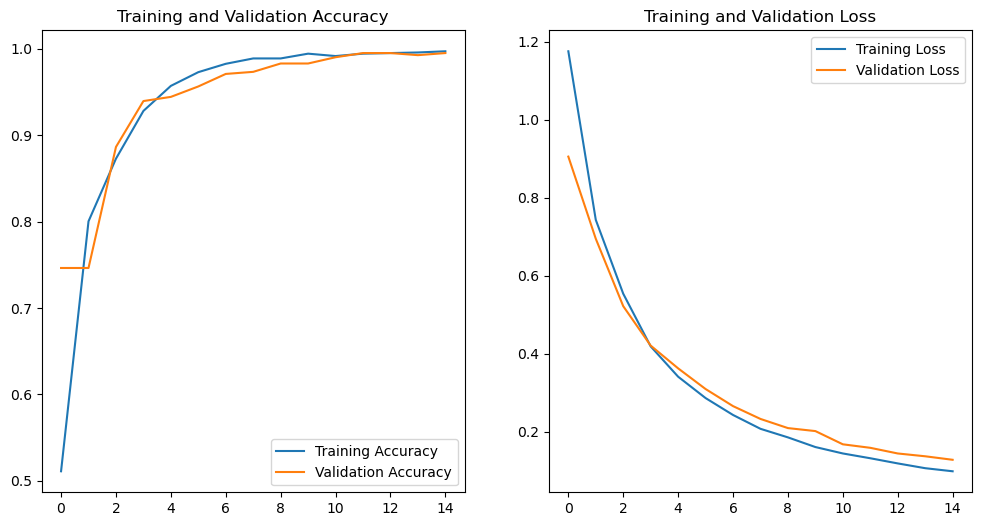

In [55]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()


In [56]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

7/7 [==============================] - 1s 128ms/step - loss: 0.1069 - accuracy: 1.0000
Test Accuracy: 1.0


In [57]:
def load_and_preprocess_image(image_path):
    # Load the image and resize it to match the training dimensions
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch dimension
    return img_array

# Get the first image
test_image_path = "DemoImage1.jpg"
test_image = load_and_preprocess_image(test_image_path)

# Predict the class of the image
predictions = model.predict(test_image)
predicted_class = class_names[np.argmax(predictions)]
print("Predicted class for the new image:", predicted_class)

# Get the second image
test_image_path = "DemoImage2.jpg"
test_image = load_and_preprocess_image(test_image_path)

# Predict the class of the image
predictions = model.predict(test_image)
predicted_class = class_names[np.argmax(predictions)]
print("Predicted class for the new image:", predicted_class)


1/1 [==============================] - 0s 498ms/step
Predicted class for the new image: acorns
1/1 [==============================] - 0s 28ms/step
Predicted class for the new image: leaves


In [24]:
import shutil
# To download the Dataset (images) locally to then upload in moodle
folder_to_zip = "AppliedML-1"
output_zip = "AppliedML-1.zip"

shutil.make_archive(output_zip.replace('.zip', ''), 'zip', folder_to_zip)
# shutil.rmtree('AppliedMLProject')

'/home/jovyan/AppliedMLProject/AppliedML-1.zip'